# ARM RWP Data

In [1]:
import act
import xarray as xr
import numpy as np
import pandas as pd
import glob

In [2]:
hi_file = glob.glob('./sgp915rwpprecipmomhiC1.a0/*')
lo_file = glob.glob('./sgp915rwpprecipmomloC1.a0/*')
dis_file = glob.glob('./sgpldquantsC1.c1/*')

In [3]:
hi_obj = act.io.armfiles.read_netcdf(hi_file)
lo_obj = act.io.armfiles.read_netcdf(lo_file)
dis_obj = act.io.armfiles.read_netcdf(dis_file)

<AxesSubplot:title={'center':'hi spectral_width on 20210627'}, xlabel='Time [UTC]', ylabel='(m)'>

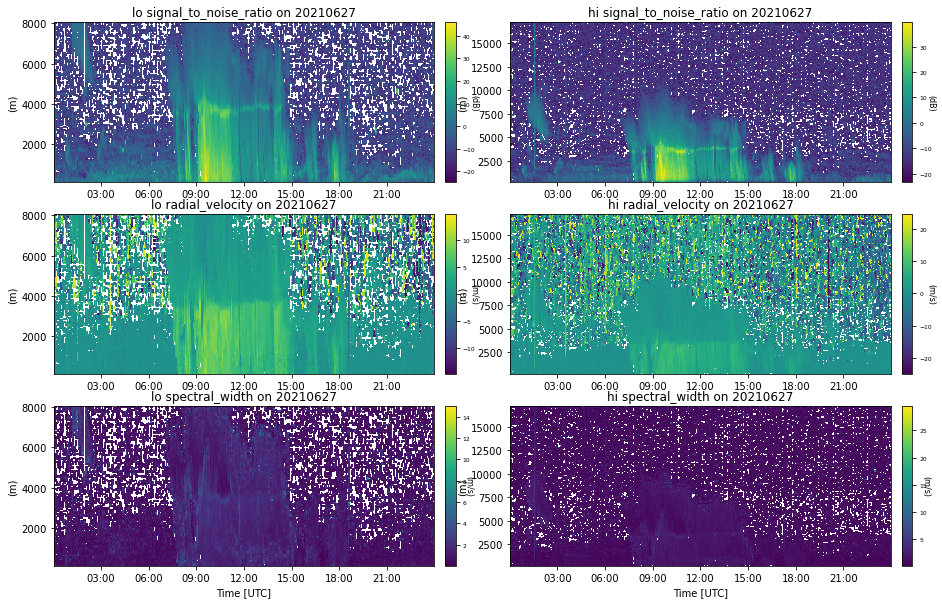

In [4]:
display = act.plotting.TimeSeriesDisplay({'lo': lo_obj, 'hi': hi_obj}, figsize=(15,10), subplot_shape=(3,2))
display.plot('signal_to_noise_ratio', dsname='lo', subplot_index=(0,0))
display.plot('radial_velocity', dsname='lo', subplot_index=(1,0))
display.plot('spectral_width', dsname='lo', subplot_index=(2,0))

display.plot('signal_to_noise_ratio', dsname='hi', subplot_index=(0,1))
display.plot('radial_velocity', dsname='hi', subplot_index=(1,1))
display.plot('spectral_width', dsname='hi', subplot_index=(2,1))

In [5]:
# SNR Filter for lo mode
# Take last 2 points
snr_lo = lo_obj['signal_to_noise_ratio'].values[:,-2:]

# Throw out larger return that could be echo
idx = np.where(snr_lo > -15)
snr_lo[idx] = np.nan
lo_mean = np.nanmean(snr_lo)
lo_std = np.nanstd(snr_lo)
lo_threshold = lo_mean + 10. * lo_std

# SNR Filter for lo mode
# Take last 2 points
snr_hi = hi_obj['signal_to_noise_ratio'].values[:,-2:]

# Throw out larger return that could be echo
idx = np.where(snr_hi > -15)
snr_hi[idx] = np.nan
hi_mean = np.nanmean(snr_hi)
hi_std = np.nanstd(snr_hi)
hi_threshold = hi_mean + 10. * hi_std

lo_obj = lo_obj.where(lo_obj.signal_to_noise_ratio > lo_threshold)
hi_obj = hi_obj.where(hi_obj.signal_to_noise_ratio > hi_threshold)
print(lo_threshold, hi_threshold)


-6.326678037643433 -3.76545786857605


In [6]:
# Boxcar filter
snr_lo = lo_obj['signal_to_noise_ratio'].values
vr_lo = lo_obj['radial_velocity'].values
sw_lo = lo_obj['spectral_width'].values

#LO Boxcar
n_time = np.shape(snr_lo)[0]
n_bins = np.shape(snr_lo)[1]
ct = np.zeros([n_time, n_bins])

for i in range(2, n_time-3):
    for j in range(2, n_bins-3):
        if np.sum(snr_lo[i-2:i+2, j-2:j+2] > lo_threshold) >= 10:
            ct[i, j] = 1

mask = np.where(ct != 1)
snr_lo[mask] = np.nan
vr_lo[mask] = np.nan
sw_lo[mask] = np.nan
lo_obj.signal_to_noise_ratio.values = snr_lo
lo_obj.radial_velocity.values = vr_lo
lo_obj.spectral_width.values = sw_lo

# HI Boxcar
snr_hi = hi_obj['signal_to_noise_ratio'].values
vr_hi = hi_obj['radial_velocity'].values
sw_hi = hi_obj['spectral_width'].values
n_time = np.shape(snr_hi)[0]
n_bins = np.shape(snr_hi)[1]
ct = np.zeros([n_time, n_bins])
for i in range(2, n_time-3):
    for j in range(2, n_bins-3):
        if np.sum(snr_hi[i-2:i+2, j-2:j+2] > hi_threshold) >= 10:
            ct[i, j] = 1
            
mask = np.where(ct != 1)
snr_hi[mask] = np.nan
vr_hi[mask] = np.nan
sw_hi[mask] = np.nan

hi_obj.signal_to_noise_ratio.values = snr_hi
hi_obj.radial_velocity.values = vr_hi
hi_obj.spectral_width.values = sw_hi

<AxesSubplot:title={'center':'hi spectral_width on 20210627'}, xlabel='Time [UTC]', ylabel='(m)'>

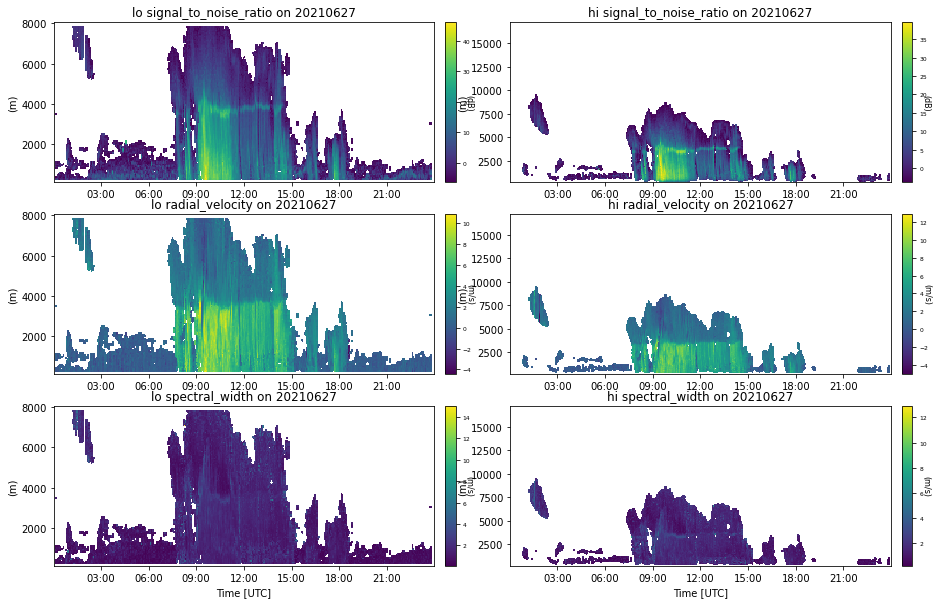

In [7]:
display = act.plotting.TimeSeriesDisplay({'lo': lo_obj, 'hi': hi_obj}, figsize=(15,10), subplot_shape=(3,2))
display.plot('signal_to_noise_ratio', dsname='lo', subplot_index=(0,0))
display.plot('radial_velocity', dsname='lo', subplot_index=(1,0))
display.plot('spectral_width', dsname='lo', subplot_index=(2,0))

display.plot('signal_to_noise_ratio', dsname='hi', subplot_index=(0,1))
display.plot('radial_velocity', dsname='hi', subplot_index=(1,1))
display.plot('spectral_width', dsname='hi', subplot_index=(2,1))

-11.351636


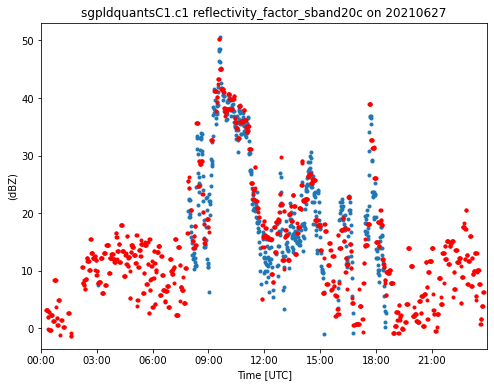

In [8]:
variable = 'reflectivity_factor_sband20c'

# Resample data to 1 minute grid to get on same time
lo_obj = lo_obj.resample(time='1min').nearest()
dis_obj = dis_obj.resample(time='1min').nearest()
obj = xr.merge([lo_obj, dis_obj], compat='override')

# Get snr and height data
snr_lo = obj['signal_to_noise_ratio'].values
height = obj['height'].values

# Get height index closest to 500
h_ind = np.argmin(np.abs(height-500.))

# Z = SNR + 20.0*Log(range) - COEFF
rwp_z = snr_lo + 20.0 * np.log10(height/1000.)
rwp_z = rwp_z[:,h_ind]

# Only use data between 30 and 35 dB
dis_z = obj[variable].values
idx = np.where((dis_z > 35.) | (dis_z < 30.))
dis_z[idx] = np.nan

# Different between rwp calculated Z and disdrometer Z
lo_diff = np.nanmean(rwp_z - dis_z)
print(lo_diff)

# Plot out disdrometer data and compare
display = act.plotting.TimeSeriesDisplay(dis_obj, figsize=(8, 6))
display.plot(variable)
display.axes[0].plot(obj.time.values, rwp_z - lo_diff, 'r.')

-21.42427


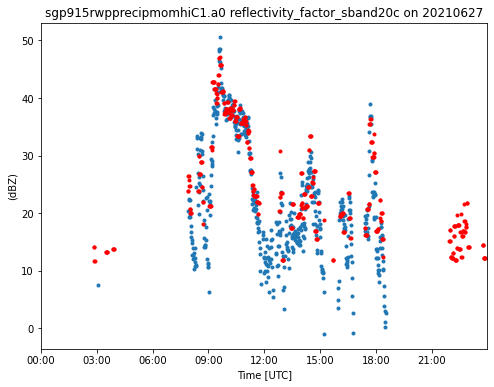

In [9]:
variable = 'reflectivity_factor_sband20c'

# Resample data to 1 minute grid to get on same time
hi_obj = hi_obj.resample(time='1min').nearest()
obj = xr.merge([hi_obj, dis_obj], compat='override')

# Get snr and height data
snr_hi = obj['signal_to_noise_ratio'].values
height = obj['height'].values

# Get height index closest to 500
h_ind = np.argmin(np.abs(height-500.))

# Z = SNR + 20.0*Log(range) - COEFF
rwp_z = snr_hi + 20.0 * np.log10(height/1000.)
rwp_z = rwp_z[:,h_ind]

# Only use data between 25 and 35 dB
dis_z = obj[variable].values
idx = np.where((dis_z > 35.) | (dis_z < 30.))
dis_z[idx] = np.nan

# Different between rwp calculated Z and disdrometer Z
hi_diff = np.nanmean(rwp_z - dis_z)
print(hi_diff)

# Plot out disdrometer data and compare
display = act.plotting.TimeSeriesDisplay(obj, figsize=(8, 6))
display.plot(variable)
display.axes[0].plot(obj.time.values, rwp_z - hi_diff, 'r.')